# Leveraging Qiskit Runtime 

Iterative algorithms, such as the Variational Quantum Eigensolver (VQE), traditionally send one batch of circuits (one "job") to be executed on the quantum device in each iteration. Sending a job involves certain overhead, mainly

* the time to process the requests and send the data (API overhead, usually about 10s)
* the job queue time, that is how long you have to wait before it's your turn to run on the device (usually about 2min)

If we send hundreds of jobs iteratively, this overhead quickly dominates the execution time of our algorithm.
Qiskit Runtime allows us to tackle these issues and significantly speed up (especially) iterative algorithms. With Qiskit Runtime, one job does not contain only a batch of circuits but the _entire_ algorithm. That means we only experience the API overhead and queue wait _once_ instead of in every iteration! You'll be able to either upload algorithm parameters and delegate all the complexity to the cloud, where your program is executed, or upload your personal algorithm directly.

For the VQE, the integration of Qiskit Runtime in your existing code is a piece of cake. There is a (almost) drop-in replacement, called `VQEClient` for the `VQE` class.

Let's see how you can leverage the runtime on a simple chemistry example: Finding the ground state energy of the lithium hydrate (LiH) molecule at a given bond distance.

### *Important: Version requirements*

*This notebook requires a minimum version number of Qiskit Terra 0.22.0 and Qiskit Nature 0.5.0.*

## Problem specification: LiH molecule

First, we specify the molecule whose ground state energy we seek. Here, we look at LiH with a bond distance of 2.5 Å.

In [1]:
from qiskit_nature.units import DistanceUnit
from qiskit_nature.second_q.drivers import PySCFDriver
from qiskit_nature.second_q.mappers import QubitConverter
from qiskit_nature.second_q.mappers import ParityMapper
from qiskit_nature.second_q.properties import ParticleNumber
from qiskit_nature.second_q.transformers import ActiveSpaceTransformer

In [2]:
bond_distance = 2.5  # in Angstrom

# specify driver
driver = PySCFDriver(
    atom=f"Li 0 0 0; H 0 0 {bond_distance}",
    basis="sto3g",
    charge=0,
    spin=0,
    unit=DistanceUnit.ANGSTROM,
)
problem = driver.run()

# specify active space transformation
active_space_trafo = ActiveSpaceTransformer(
    num_electrons=problem.num_particles, num_spatial_orbitals=3
)

# transform the electronic structure problem
problem = active_space_trafo.transform(problem)

# construct qubit converter (parity mapping + 2-qubit reduction)
qubit_converter = QubitConverter(ParityMapper(), two_qubit_reduction=True)

## Classical reference solution

As a reference solution we can solve this system classically with the `NumPyEigensolver`.

In [3]:
from qiskit.algorithms.minimum_eigensolvers import NumPyMinimumEigensolver
from qiskit_nature.second_q.algorithms.ground_state_solvers import GroundStateEigensolver

np_solver = NumPyMinimumEigensolver()
np_groundstate_solver = GroundStateEigensolver(qubit_converter, np_solver)

np_result = np_groundstate_solver.solve(problem)

In [19]:
target_energy = np_result.total_energies[0]
print(np_result)

=== GROUND STATE ENERGY ===
 
* Electronic ground state energy (Hartree): -8.408630641972
  - computed part:      -8.408630641972
  - ActiveSpaceTransformer extracted energy part: 0.0
~ Nuclear repulsion energy (Hartree): 0.635012653104
> Total ground state energy (Hartree): -7.773617988868
 
=== MEASURED OBSERVABLES ===
 
  0:  # Particles: 4.000 S: 0.000 S^2: 0.000 M: 0.000
 
=== DIPOLE MOMENTS ===
 
~ Nuclear dipole moment (a.u.): [0.0  0.0  4.72431531]
 
  0: 
  * Electronic dipole moment (a.u.): [0.0  0.0  6.45025807]
    - computed part:      [0.0  0.0  6.45025807]
    - ActiveSpaceTransformer extracted energy part: [0.0  0.0  0.0]
  > Dipole moment (a.u.): [0.0  0.0  -1.72594276]  Total: 1.72594276
                 (debye): [0.0  0.0  -4.38690851]  Total: 4.38690851
 


## VQE

To run the VQE we need to select a parameterized quantum circuit acting as ansatz and a classical optimizer. Here we'll choose a heuristic, hardware efficient ansatz and the SPSA optimizer.

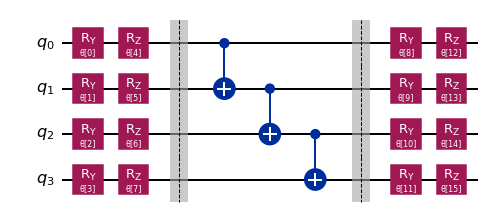

In [5]:
from qiskit.circuit.library import EfficientSU2

ansatz = EfficientSU2(num_qubits=4, reps=1, entanglement="linear", insert_barriers=True)
ansatz.decompose().draw("mpl", style="iqx")

In [6]:
import numpy as np
from qiskit.utils import algorithm_globals

# fix random seeds for reproducibility

np.random.seed(5)
algorithm_globals.random_seed = 5

In [7]:
from qiskit.algorithms.optimizers import SPSA

optimizer = SPSA(maxiter=100)

initial_point = np.random.random(ansatz.num_parameters)

Before executing the VQE in the cloud using Qiskit Runtime, let's execute a local VQE first.

In [8]:
from qiskit.algorithms.minimum_eigensolvers import VQE
from qiskit.primitives import Estimator

estimator = Estimator()

local_vqe = VQE(
    estimator,
    ansatz,
    optimizer,
    initial_point=initial_point,
)

local_vqe_groundstate_solver = GroundStateEigensolver(qubit_converter, local_vqe)

local_vqe_result = local_vqe_groundstate_solver.solve(problem)

In [9]:
print(local_vqe_result)

=== GROUND STATE ENERGY ===
 
* Electronic ground state energy (Hartree): -8.223473551005
  - computed part:      -8.223473551005
  - ActiveSpaceTransformer extracted energy part: 0.0
~ Nuclear repulsion energy (Hartree): 0.635012653104
> Total ground state energy (Hartree): -7.588460897901
 
=== MEASURED OBSERVABLES ===
 
  0:  # Particles: 3.997 S: 0.438 S^2: 0.631 M: 0.001
 
=== DIPOLE MOMENTS ===
 
~ Nuclear dipole moment (a.u.): [0.0  0.0  4.72431531]
 
  0: 
  * Electronic dipole moment (a.u.): [0.0  0.0  1.41136787]
    - computed part:      [0.0  0.0  1.41136787]
    - ActiveSpaceTransformer extracted energy part: [0.0  0.0  0.0]
  > Dipole moment (a.u.): [0.0  0.0  3.31294744]  Total: 3.31294744
                 (debye): [0.0  0.0  8.42067168]  Total: 8.42067168
 


## Runtime VQE

Let's exchange the eigensolver from a local VQE algorithm to a VQE executed using Qiskit Runtime -- simply by exchanging the `VQE` class by the `qiskit_nature.runtime.VQEClient`.

First, we'll have to load a provider to access Qiskit Runtime. **Note:** You have to replace the next cell with your provider.

In [10]:
from qiskit import IBMQ

IBMQ.load_account()
provider = IBMQ.get_provider(group="open")  # replace by your runtime provider

backend = provider.get_backend("ibmq_qasm_simulator")  # select a backend that supports the runtime

Now we can set up the `VQEClient`. In this first release, the optimizer must be provided as a dictionary, in future releases you'll be able to pass the same optimizer object as in the traditional VQE.

In [11]:
from qiskit_nature.runtime import VQEClient

runtime_vqe = VQEClient(
    ansatz=ansatz,
    optimizer=optimizer,
    initial_point=initial_point,
    provider=provider,
    backend=backend,
    shots=1024,
    measurement_error_mitigation=True,
)  # use a complete measurement fitter for error mitigation

In [12]:
runtime_vqe_groundstate_solver = GroundStateEigensolver(qubit_converter, runtime_vqe)
runtime_vqe_result = runtime_vqe_groundstate_solver.solve(problem)

In [13]:
print(runtime_vqe_result)

=== GROUND STATE ENERGY ===
 
* Electronic ground state energy (Hartree): -8.172591259069
  - computed part:      -8.172591259069
  - ActiveSpaceTransformer extracted energy part: 0.0
~ Nuclear repulsion energy (Hartree): 0.635012653104
> Total ground state energy (Hartree): -7.537578605965
 
=== MEASURED OBSERVABLES ===
 
  0:  # Particles: 3.988 S: 0.596 S^2: 0.951 M: 0.002
 
=== DIPOLE MOMENTS ===
 
~ Nuclear dipole moment (a.u.): [0.0  0.0  4.72431531]
 
  0: 
  * Electronic dipole moment (a.u.): [0.0  0.0  1.25645131]
    - computed part:      [0.0  0.0  1.25645131]
    - ActiveSpaceTransformer extracted energy part: [0.0  0.0  0.0]
  > Dipole moment (a.u.): [0.0  0.0  3.467864]  Total: 3.467864
                 (debye): [0.0  0.0  8.81443024]  Total: 8.81443024
 


If we are interested in the development of the energy, the `VQEClient` allows access to the history of the optimizer, which contains the loss per iteration (along with the parameters and a timestamp). Note that this only holds for the SPSA and QN-SPSA optimizers. Otherwise you have to use a callback to the `VQEClient`, similar to the normal `VQE`.

We can access this data via the `raw_result` attribute of the ground state solver.

In [17]:
runtime_result = runtime_vqe_result.raw_result
history = runtime_result.optimizer_history
loss = history["energy"]

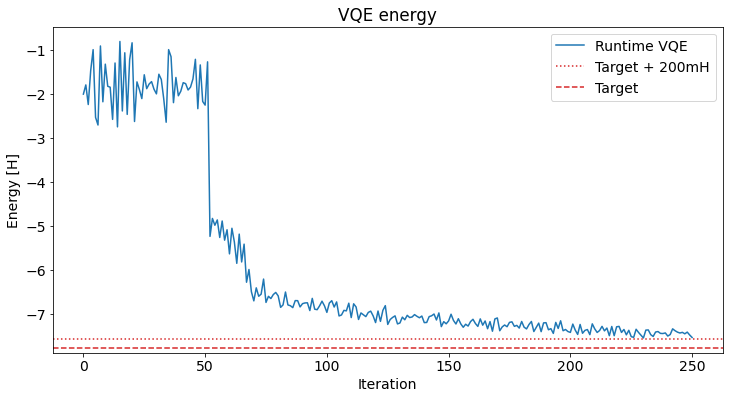

In [20]:
import matplotlib.pyplot as plt

plt.rcParams["font.size"] = 14

# plot loss and reference value
plt.figure(figsize=(12, 6))
plt.plot(loss + runtime_vqe_result.nuclear_repulsion_energy, label="Runtime VQE")
plt.axhline(y=target_energy + 0.2, color="tab:red", ls=":", label="Target + 200mH")
plt.axhline(y=target_energy, color="tab:red", ls="--", label="Target")

plt.legend(loc="best")
plt.xlabel("Iteration")
plt.ylabel("Energy [H]")
plt.title("VQE energy");

In [21]:
import qiskit.tools.jupyter

%qiskit_version_table
%qiskit_copyright